# Residual Neural Network

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time

slim = tf.contrib.slim

/home/jk/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
tf.reset_default_graph()

# import data set

In [3]:
(x_train, y_train), (x_test, y_test) =  tf.keras.datasets.mnist.load_data()

x_train = x_train/255.0
x_train = x_train.astype(dtype=np.float32)
y_train = np.asarray(y_train, dtype=np.int32)

x_test = x_test/255.0
x_test = x_test.astype(np.float32)
y_test = np.asarray(y_test, dtype=np.int32)

In [4]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [5]:
#sampling
train_data_size  = 6000
train_idx = np.random.choice(np.arange(x_train.shape[0]), size=train_data_size, replace=False)
# print(train_idx)
x_train = x_train[train_idx]
y_train = y_train[train_idx]

train_data_size  = 2000
test_idx = np.random.choice(np.arange(x_train.shape[0]), size=train_data_size, replace=False)
# print(train_idx)
x_test = x_test[test_idx]
y_test = y_test[test_idx]

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((6000, 28, 28), (6000,), (2000, 28, 28), (2000,))

# split data

In [6]:
# train_data_size  = 50000
train_data_size  = 5000
train_idx = np.random.choice(np.arange(x_train.shape[0]), size=train_data_size, replace=False)
# print(train_idx)
x_tr = x_train[train_idx]
y_tr = y_train[train_idx]

x_val = np.delete(arr=x_train, obj=train_idx, axis=0)
y_val = np.delete(arr=y_train, obj=train_idx, axis=0)

print('train data : {}, {}'.format(x_tr.shape, y_tr.shape))
print('val data : {}, {}'.format(x_val.shape, y_val.shape))

train data : (5000, 28, 28), (5000,)
val data : (1000, 28, 28), (1000,)


# setup dataset with tf.data

In [7]:
batch_size  = 32

# for training
tr_dataset = tf.data.Dataset.from_tensor_slices((x_tr, y_tr))
# tr_dataset = tr_dataset.shuffle(buffer_size = 10000)
tr_dataset = tr_dataset.batch(batch_size = batch_size)
tr_iterator = tr_dataset.make_initializable_iterator()

print(tr_dataset)

# for validation
# validation data의 용량이 in memory에 넣을 수 없을정도로 아래와 같이 활용한다.
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
# val_dataset = val_dataset.shuffle(buffer_size = 10000)
val_dataset = val_dataset.batch(batch_size = batch_size)
val_iterator = val_dataset.make_initializable_iterator()

print(val_dataset)

<BatchDataset shapes: ((?, 28, 28), (?,)), types: (tf.float32, tf.int32)>
<BatchDataset shapes: ((?, 28, 28), (?,)), types: (tf.float32, tf.int32)>


In [8]:
# tf.data.Iterator.from_string_handle의 output_shapes는 default = None이지만 꼭 값을 넣는 게 좋음
handle = tf.placeholder(tf.string)
iterator = tf.data.Iterator.from_string_handle(handle,
                                               tr_dataset.output_types,
                                               tr_dataset.output_shapes)
x, y = iterator.get_next()

# build model

In [9]:
def residual_block(input_layer, kernels, filters, stride, is_training):
    """
    input -> Conv -> Relu -> Conv -> Addition -> Relu -> Output
    """
    
    conv = tf.layers.conv2d(input_layer, filters=filters, kernel_size=kernels, strides=stride, 
                    activation=None, padding='SAME')
    conv = tf.layers.batch_normalization(conv, epsilon=1e-5, training=is_training)
    conv = tf.nn.relu(conv)
    
    conv = tf.layers.conv2d(conv, filters=filters, kernel_size=kernels, strides=stride, padding='SAME')
    conv = tf.layers.batch_normalization(conv, epsilon=1e-5, training=is_training)
    
    input_projection = tf.layers.conv2d(input_layer, filters=filters, kernel_size=1, strides=1)
    conv_shortcut_connection = tf.nn.relu(tf.add(conv, input_projection))
    
    conv = tf.layers.conv2d(conv_shortcut_connection, filters=filters, kernel_size=kernels, strides=stride, 
                    activation=tf.nn.relu, padding='SAME')
    conv = tf.layers.batch_normalization(conv, epsilon=1e-5, training=is_training)
    conv = tf.nn.relu(conv)
    
    conv = tf.layers.conv2d(conv, filters=filters, kernel_size=kernels, strides=stride, padding='SAME')
    conv = tf.layers.batch_normalization(conv, epsilon=1e-5, training=is_training)
    
    conv_shortcut_connection = tf.nn.relu(tf.add(conv, conv_shortcut_connection))
    
    return tf.layers.max_pooling2d(conv_shortcut_connection, pool_size=2, strides=2, padding='SAME')

In [10]:
def cnn_model(x):
    
    is_training = tf.placeholder(tf.bool)
    
    with tf.variable_scope('input_layer'):
        input_layer = tf.reshape(x, shape=[-1, 28, 28, 1])
        # Now [batch x 28 x 28 x 1]
        conv = tf.layers.conv2d(input_layer, filters=8, kernel_size=3, strides=1, padding='SAME',
                               activation=tf.nn.relu)
        # Now [batch x 28 x 28 x 8]
        
    with tf.variable_scope('residual_1'):
        conv = residual_block(conv, kernels=3, filters=16, stride=1, is_training=is_training)
        # Now [batch x 14 x 14 x 16]
    with tf.variable_scope('residual_2'):
        conv = residual_block(conv, kernels=3, filters=32, stride=1, is_training=is_training)
        # Now [batch x 7 x 7 x 32]
    with tf.variable_scope('residual_3'):
        conv = residual_block(conv, kernels=3, filters=64, stride=1, is_training=is_training)
        # Now [batch x 4 x 4 x 64]
        
    with tf.variable_scope('dense'):
        flatten = tf.reshape(conv, [-1, 4*4*64]) # tf.layer.flatten(conv)
    
        fc1 = tf.layers.dense(flatten, 1024, activation=tf.nn.relu, name='fc1')
        
        dropout = tf.layers.dropout(fc1, rate=0.4, training=is_training, name='dropout')
        logits = tf.layers.dense(dropout, 10, name='logits')
        
        return logits, is_training, input_layer

In [11]:
logits, is_training, x_image = cnn_model(x)

# define loss and optimizer

In [12]:
cross_entropy = tf.losses.sparse_softmax_cross_entropy(labels=y, logits=logits)

with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
    train_step = tf.train.AdamOptimizer().minimize(cross_entropy)

# assign tf.summary.filewriter

In [13]:
graph_location = 'graphs/tensorflow_resnet'
print('Saving grapg to: %s' % graph_location)
# open FileWriter
train_writer = tf.summary.FileWriter(graph_location)
# add current default graph to the writer
train_writer.add_graph(tf.get_default_graph())

Saving grapg to: graphs/tensorflow_resnet


# tf.summary

In [14]:
with tf.name_scope('summaries'):
    tf.summary.scalar('loss/cross_entropy', cross_entropy)
    tf.summary.image('images', x_image)
    for var in tf.trainable_variables():
        tf.summary.histogram(var.op.name, var)
    summary_op = tf.summary.merge_all()

# tf.session and train

In [15]:
# sess_config = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True))
sess_config = tf.ConfigProto()
sess = tf.Session(config=sess_config)
sess.run(tf.global_variables_initializer())

# history
tr_hist = []
val_hist = []

# Generate handles of tr_iterator and val_iterator
tr_handle, val_handle = sess.run(fetches = [tr_iterator.string_handle(), val_iterator.string_handle()])

# Train
max_epochs = 10

In [16]:
for epoch in range(max_epochs):
    
    avg_tr_loss = 0
    avg_val_loss = 0
    tr_step = 0
    val_step = 0
    
    # training 1-epoch
    sess.run(tr_iterator.initializer)
    start_time = time.time()
    
    while True:
        try:
#             print(tr_step)
            _, tr_loss = sess.run(fetches = [train_step, cross_entropy],
                               feed_dict = {handle : tr_handle, is_training : True})
            
            
            if tr_step % 100 == 0:
                summary_str = sess.run(summary_op, feed_dict={handle: tr_handle, is_training: False})
                train_writer.add_summary(summary_str, global_step=tr_step)
            tr_step += 1
            avg_tr_loss += tr_loss

        except tf.errors.OutOfRangeError:
            break
    print("Epoch: {} Training Elapsed Time : {}".format(epoch, time.time()-start_time))
    
    # validation 1-epoch
    sess.run(val_iterator.initializer)
    while True:
        try:
            val_loss = sess.run(cross_entropy, 
                                feed_dict = {handle : val_handle, is_training : False})
            val_step += 1
            avg_val_loss += val_loss
        
        except tf.errors.OutOfRangeError:
            break
            
    avg_tr_loss /= tr_step
    avg_val_loss /= val_step
    tr_hist.append(avg_tr_loss)
    val_hist.append(avg_val_loss)
    
    print('epochs : {:3}, tr_loss : {:.3f}, val_loss : {:.3f}'.format(epoch + 1, avg_tr_loss, avg_val_loss))

Epoch: 0 Training Elapsed Time : 59.14239573478699
epochs :   1, tr_loss : 1.149, val_loss : 5.016
Epoch: 1 Training Elapsed Time : 53.094382762908936
epochs :   2, tr_loss : 0.212, val_loss : 8.413
Epoch: 2 Training Elapsed Time : 53.07544732093811
epochs :   3, tr_loss : 0.141, val_loss : 4.246
Epoch: 3 Training Elapsed Time : 52.980950117111206
epochs :   4, tr_loss : 0.098, val_loss : 0.192
Epoch: 4 Training Elapsed Time : 52.98998165130615
epochs :   5, tr_loss : 0.068, val_loss : 0.160
Epoch: 5 Training Elapsed Time : 58.74895787239075
epochs :   6, tr_loss : 0.062, val_loss : 0.277
Epoch: 6 Training Elapsed Time : 54.29810667037964
epochs :   7, tr_loss : 0.063, val_loss : 0.144
Epoch: 7 Training Elapsed Time : 53.83039736747742
epochs :   8, tr_loss : 0.062, val_loss : 0.085
Epoch: 8 Training Elapsed Time : 54.951926708221436
epochs :   9, tr_loss : 0.053, val_loss : 0.111
Epoch: 9 Training Elapsed Time : 57.48037147521973
epochs :  10, tr_loss : 0.038, val_loss : 0.157


# test trained model

In [17]:
yhat = sess.run(logits, feed_dict = {x : x_test, is_training : False})
yhat = np.argmax(yhat, axis = 1)

In [18]:
print('test accuracy : {:.2%}'.format(np.mean(yhat == y_test)))

test accuracy : 96.80%


# visualize history

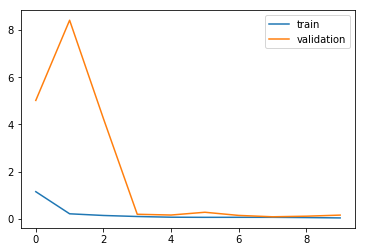

In [19]:
plt.plot(tr_hist, label = 'train')
plt.plot(val_hist, label = 'validation')
plt.legend()